In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./input/test.csv').set_index('ID')

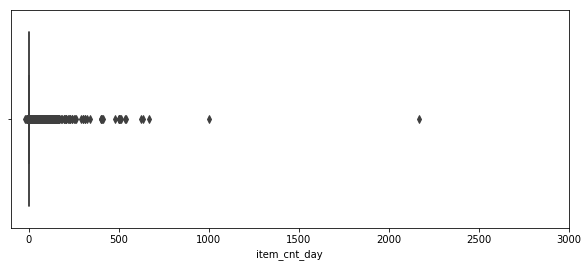

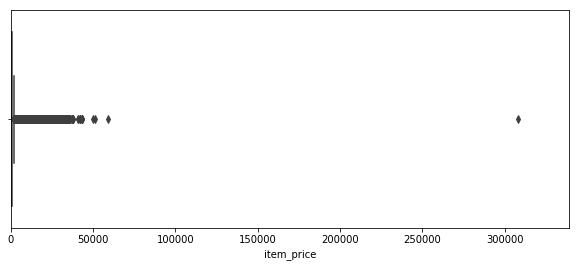

In [60]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [76]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

In [77]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [14]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [94]:
ss = pd.read_csv('./input/shops.csv')

In [101]:
ss['shop_name'][0]

'!Якутск Орджоникидзе, 56 фран'

In [103]:
type(ss['shop_name'].str)

pandas.core.strings.StringMethods

```
小技巧： 
1. 先 dataframe.str 取出每個 row 的 string 最後只取空白前面的字串
2. LabelEncoder().fit_transform(shops['city']) 可以把不同的城市名稱用數字來代表一類
```

In [79]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [8]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

```
小技巧：
1. itertools 的 product 是用來產生各種組合，這裡是 0-33 和商店 id 、物品 id的所有組合
```

In [9]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

10.694971799850464

In [10]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

```
小技巧：
1. groupby 順序滿重要的，代表不同意義，這裏 data_block_num 放第一個代表先把所有 row 依照不同月份分類，以此類推
2. agg 代表 aggregate function ，裡面用 dictionary 的方式表示某 column 要做哪些事
3. group 整理出來的東西代表不同月每個家商店中的某樣商品共賣了多少量
4. pd.merge 是把兩個 dataframe 合併，但合併有很多方式，這裡用的是依照相同的欄位 ['date_block_num','shop_id','item_id'] 來把 group 合併到 matrix 中，此外因為是 left 合併而 matrix 中有很多欄位是 group 沒有的所以合併後的 dataframe 會有很多 NaN
5. 為了解決 NaN 的問題所以用到 fillna(0) ，把所有缺值改成 0
6. clip 是用來限制欄位中的值的大小不能低於地板 (0)，也不能高於天花板 (20)
```

In [11]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

4.992633104324341

小技巧：
1. 用 astype 轉型讓 dataframe 空間小點(numpy.int64 -> numpy.int8)

In [15]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

```
把 testing data 月份標記成第 34 個月，加在 matrix tail 的部分，並把銷售量先填 0
```

In [13]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.1010749340057373

```
直接 merge 也不會有空值，因為 matrix 裡面的 shop_id ， shops 裡面一定也有，同理 items, cats 也是
```

In [14]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

3.781827211380005

```
lag_feature function 可以新增上＿個月的資料
```

In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

```
新增欄位分別是商品 1,2,3,6,12 個月前的銷售量
merge 之後有很多缺值
```

In [16]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

30.820859909057617

```
新增一個欄位代表上個月所有物品的平均銷售量
```

In [17]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

10.093020915985107

```
新增欄位代表上 1,2,3,6,12 個月該物品的平均銷售量
```

In [18]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

37.40001821517944

```
新增欄位代表上 1,2,3,6,12 個月該商店的平均銷售量
```

In [19]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

39.19316792488098

```
新增一個欄位代表上個月該類物品的平均銷售量
```

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.198522090911865

```
新增一個欄位代表上個月該商店中某類物品的平均銷售量
```

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.519139051437378

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.855093955993652

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.848094940185547

```
新增一個欄位代表上個月該城市中物品的平均銷售量
```

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.810953855514526

```
新增一個欄位代表上個月該城市中某物品的平均銷售量
```

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.433680772781372

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.069359064102173

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.825735807418823

In [28]:
ts = time.time()
########### 算出每件商品的平均價格 ##############
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
##############################################

######## 算出同個月內每件商品的平均價格 ###########
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
##############################################

########## 新增上 1,2,3,4,5,6 個月各項商品的平均價格 ####### 
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')
#######################################################

#### 計算前幾個月商品的平均價格跟商品一直以來的平均價格的價差 ########
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
#####################################################
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

328.17624497413635

In [29]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

19.56959295272827

```
新增每個 row 是代表哪個月、有幾天
```

In [33]:
matrix['month'] = matrix['date_block_num'] % 12

In [34]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

```
計算某商店中的商品最後一次被買距離上一次被買過了幾個月
小技巧：Hashtable
```

In [35]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1436.4019820690155

In [36]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

916.6287770271301

```
計算某商店中的商品被買時距離第一次被買過了幾個月
小技巧：groupby 之後使用 aggregate
```

In [37]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.9454848766326904

```
因為用很多幾個月前的資料 (最多到前 12 個月) 代表前 12 個月的資料很多都是空的，因此要 drop 掉
```

In [38]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.2080228328704834

In [39]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

4.910508871078491

In [40]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [41]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [42]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [4]:
data = pd.read_pickle('data.pkl')

In [5]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
#     'date_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_2',
#     'date_item_avg_item_cnt_lag_3',
#     'date_item_avg_item_cnt_lag_6',
#     'date_item_avg_item_cnt_lag_12',
#     'date_shop_avg_item_cnt_lag_1',
#     'date_shop_avg_item_cnt_lag_2',
#     'date_shop_avg_item_cnt_lag_3',
#     'date_shop_avg_item_cnt_lag_6',
#     'date_shop_avg_item_cnt_lag_12',
#     'date_cat_avg_item_cnt_lag_1',
#     'date_shop_cat_avg_item_cnt_lag_1',
#     'date_shop_type_avg_item_cnt_lag_1',
#     'date_shop_subtype_avg_item_cnt_lag_1',
#     'date_city_avg_item_cnt_lag_1',
#     'date_item_city_avg_item_cnt_lag_1',
#     'date_type_avg_item_cnt_lag_1',
#     'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [7]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,delta_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,-0.282715,0,31,1,1,12,12
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,-0.483398,0,31,1,1,11,11
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0,-0.137451,0,31,1,1,11,11
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,-0.407227,0,31,-1,1,12,12
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0,-0.225464,0,31,1,1,12,12


In [6]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [86]:
del data
gc.collect();

In [10]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.4,  # Learning rate
    nthread=8,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.15236	validation_1-rmse:1.11931
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11702	validation_1-rmse:1.09099
[2]	validation_0-rmse:1.0731	validation_1-rmse:1.05847
[3]	validation_0-rmse:1.04113	validation_1-rmse:1.03225
[4]	validation_0-rmse:1.01246	validation_1-rmse:1.01021
[5]	validation_0-rmse:0.986389	validation_1-rmse:0.991956
[6]	validation_0-rmse:0.964633	validation_1-rmse:0.977407
[7]	validation_0-rmse:0.951032	validation_1-rmse:0.967113
[8]	validation_0-rmse:0.938791	validation_1-rmse:0.958452
[9]	validation_0-rmse:0.925378	validation_1-rmse:0.949198
[10]	validation_0-rmse:0.914199	validation_1-rmse:0.94308
[11]	validation_0-rmse:0.903538	validation_1-rmse:0.937356
[12]	validation_0-rmse:0.895839	validation_1-rmse:0.93375
[13]	validation_0-rmse:0.889293	validation_1-rmse:0.930265
[14]	validation_0-rmse:0.882955	valida

310.94425797462463

In [17]:
ts = time.time()

model = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.4,  # Learning rate
    nthread=8,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.15329	validation_1-rmse:1.12146
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11985	validation_1-rmse:1.09355
[2]	validation_0-rmse:1.07694	validation_1-rmse:1.06238
[3]	validation_0-rmse:1.04554	validation_1-rmse:1.03597
[4]	validation_0-rmse:1.01902	validation_1-rmse:1.01682
[5]	validation_0-rmse:0.992806	validation_1-rmse:0.998278
[6]	validation_0-rmse:0.971415	validation_1-rmse:0.984658
[7]	validation_0-rmse:0.95849	validation_1-rmse:0.97504
[8]	validation_0-rmse:0.946668	validation_1-rmse:0.967067
[9]	validation_0-rmse:0.933969	validation_1-rmse:0.957033
[10]	validation_0-rmse:0.923285	validation_1-rmse:0.949666
[11]	validation_0-rmse:0.911937	validation_1-rmse:0.943084
[12]	validation_0-rmse:0.904828	validation_1-rmse:0.939156
[13]	validation_0-rmse:0.898619	validation_1-rmse:0.934566
[14]	validation_0-rmse:0.89304	valida

[137]	validation_0-rmse:0.816396	validation_1-rmse:0.898391
[138]	validation_0-rmse:0.816296	validation_1-rmse:0.898314
[139]	validation_0-rmse:0.816221	validation_1-rmse:0.898307
[140]	validation_0-rmse:0.816136	validation_1-rmse:0.898242
[141]	validation_0-rmse:0.81585	validation_1-rmse:0.897952
[142]	validation_0-rmse:0.815777	validation_1-rmse:0.898026
[143]	validation_0-rmse:0.815712	validation_1-rmse:0.898111
[144]	validation_0-rmse:0.815649	validation_1-rmse:0.897993
[145]	validation_0-rmse:0.815579	validation_1-rmse:0.897952
[146]	validation_0-rmse:0.815473	validation_1-rmse:0.897825
[147]	validation_0-rmse:0.81539	validation_1-rmse:0.897728
[148]	validation_0-rmse:0.81499	validation_1-rmse:0.898112
[149]	validation_0-rmse:0.814807	validation_1-rmse:0.898205
[150]	validation_0-rmse:0.814597	validation_1-rmse:0.898069
[151]	validation_0-rmse:0.814466	validation_1-rmse:0.898031
[152]	validation_0-rmse:0.814373	validation_1-rmse:0.898043
[153]	validation_0-rmse:0.813989	validation

441.20721101760864

In [19]:
ts = time.time()

model = XGBRegressor(
    max_depth=6,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.4,  # Learning rate
    nthread=8,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.15447	validation_1-rmse:1.12334
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.12229	validation_1-rmse:1.09655
[2]	validation_0-rmse:1.0843	validation_1-rmse:1.06718
[3]	validation_0-rmse:1.05087	validation_1-rmse:1.04346
[4]	validation_0-rmse:1.02479	validation_1-rmse:1.02418
[5]	validation_0-rmse:0.999108	validation_1-rmse:1.00609
[6]	validation_0-rmse:0.978589	validation_1-rmse:0.993417
[7]	validation_0-rmse:0.966378	validation_1-rmse:0.983814
[8]	validation_0-rmse:0.956404	validation_1-rmse:0.975754
[9]	validation_0-rmse:0.942455	validation_1-rmse:0.965903
[10]	validation_0-rmse:0.931892	validation_1-rmse:0.959046
[11]	validation_0-rmse:0.921156	validation_1-rmse:0.952226
[12]	validation_0-rmse:0.914404	validation_1-rmse:0.9479
[13]	validation_0-rmse:0.908431	validation_1-rmse:0.944394
[14]	validation_0-rmse:0.902992	validat

304.5328209400177

In [20]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

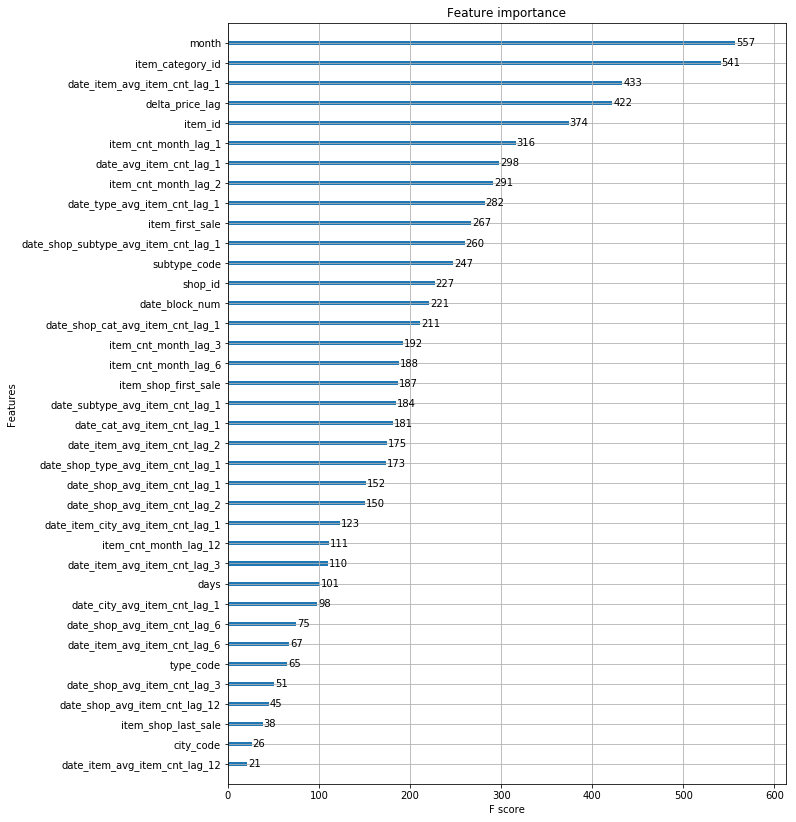

In [179]:
plot_features(model, (10,14))

# 目前最好
## model:
```
model:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.35,  # Learning rate
    nthread=8,
    seed=56)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts
```
## data:
```
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]
```

In [22]:
s1 = pd.read_csv("../../Downloads/xgb_submission.csv")
s2 = pd.read_csv("../../Downloads/xgb_submission (1).csv")

In [24]:
s = pd.merge(s1, s2, on=['ID'], how='left')

In [25]:
s.head()

,ID,item_cnt_month_x,item_cnt_month_y
0,0,0.580359,0.549840
1,1,0.358934,0.470411
2,2,1.199845,1.164494
3,3,0.469782,0.371240
4,4,3.862634,3.865786


In [29]:
def cnt_month_mean(x):
    return (x[0] + x[1])/2

In [32]:
s['item_cnt_month'] = s[['item_cnt_month_x','item_cnt_month_y']].apply(cnt_month_mean,axis=1)

In [33]:
s.head()

,ID,item_cnt_month_x,item_cnt_month_y,item_cnt_month
0,0,0.580359,0.549840,0.565100
1,1,0.358934,0.470411,0.414672
2,2,1.199845,1.164494,1.182169
3,3,0.469782,0.371240,0.420511
4,4,3.862634,3.865786,3.864210


In [34]:
sub = s.drop(['item_cnt_month_x','item_cnt_month_y'],axis=1)

In [35]:
sub.head()

,ID,item_cnt_month
0,0,0.565100
1,1,0.414672
2,2,1.182169
3,3,0.420511
4,4,3.864210


In [36]:
sub.to_csv('GGININDER.csv',index=False)